# Collab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

In [3]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Copy and load the data

In [4]:
BASE_PATH = '/content/drive/MyDrive/ai/rsna-brain-tumor/'

In [5]:
!ls {BASE_PATH}

rsna-brain-tumor  rsna-brain-tumor-data.zip  train_labels.csv


In [6]:
file = BASE_PATH + 'rsna-brain-tumor-data.zip'

In [7]:
%%time
!cp {file} .

CPU times: user 1.09 s, sys: 195 ms, total: 1.28 s
Wall time: 4min 12s


In [8]:
!ls

drive  rsna-brain-tumor-data.zip  sample_data


In [9]:
%%time
!unzip ./rsna-brain-tumor-data.zip -d ./rsna-brain-tumor-data > /dev/null

CPU times: user 791 ms, sys: 94.5 ms, total: 885 ms
Wall time: 2min 43s


In [10]:
file = BASE_PATH + 'train_labels.csv'

In [11]:
%%time
!cp {file} .

CPU times: user 7.03 ms, sys: 4.15 ms, total: 11.2 ms
Wall time: 518 ms


# Imports

In [12]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [13]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Git repo

In [ ]:
!git status

## Import local libs

In [14]:
os.chdir("/content/drive/My Drive/ai/rsna-brain-tumor/rsna-brain-tumor/")

In [15]:
from train import train_num_iter
from utils import get_device

from dataset import Image3DDataset
from model_simple import Simple3DNet

# Setup dataset

In [16]:
IMG_SIZE = 256
# PATH_TO_DATA = './data/'
PATH_TO_DATA = '/content/'
IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')

In [17]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
train_labels_df.shape

(585, 2)

In [18]:
from torchvision import transforms as T

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [19]:
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

585

In [20]:
image, label = train_dataset[1]
type(image), image.shape, label

(numpy.ndarray, (1, 67, 256, 256), 1)

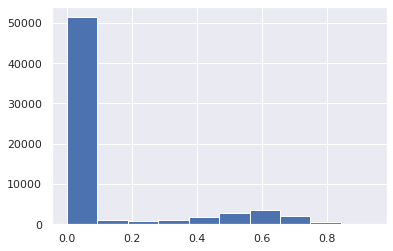

In [21]:
plt.hist(image[0, 40].reshape(-1))
plt.show()

In [22]:
# do we need to have equal D for all cases in batch?
# looks like yes
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

585

In [23]:
train_loader_iter = iter(train_loader)

In [24]:
x_batch, y_batch = next(train_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([1, 1, 23, 256, 256]), torch.Size([1]))

In [25]:
x_batch.max()

tensor(0.9922)

In [26]:
# y_batch = y_batch.long()
# y_batch = y_batch.type(torch.LongTensor)

In [27]:
y_batch, y_batch.dtype

(tensor([1]), torch.int64)

# Single model path

In [1]:
model = Simple3DNet()

NameError: ignored

In [ ]:
%%time
N, C, D, H, W = 5, 1, 26, 256, 256
X = torch.randn(N, C, D, H, W)

output = model(X)
output.shape

In [49]:
%%time
output = model(x_batch)
output.shape

CPU times: user 18.6 s, sys: 3.6 s, total: 22.2 s
Wall time: 22.2 s


In [50]:
criterion = nn.BCEWithLogitsLoss()

In [51]:
# output.dtype, y_batch.dtype

In [52]:
y_batch = y_batch.type_as(output)
loss = criterion(output.squeeze(1), y_batch)

In [53]:
loss

tensor(0.6732, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [54]:
output, y_batch

(tensor([[0.0402]], grad_fn=<AddmmBackward>), tensor([1.]))

In [55]:
output.shape, y_batch.shape

(torch.Size([1, 1]), torch.Size([1]))

In [56]:
indices = torch.argmax(output, 1)
indices

tensor([0])

In [57]:
y_pred = (output > 0)
# y_pred = torch.sigmoid(output)
# y_pred = y_pred > 0.5
y_pred.shape

torch.Size([1, 1])

In [58]:
correct_samples = torch.sum(y_pred == y_batch)
correct_samples

tensor(1)

In [59]:
y_batch.shape[0]

1

# Overfit small dataset

In [67]:
train_number = 4
train_df = train_labels_df.sample(frac=1).reset_index(drop=True).head(train_number)
train_df

,BraTS21ID,MGMT_value
0,367,1
1,203,1
2,102,0
3,157,0


In [68]:
train_dataset = Image3DDataset(train_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

4

In [69]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

4

In [63]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [74]:
max_iter = 400
print_every = 10

model = Simple3DNet().to(device)

learning_rate = 0.001
weight_decay = 0

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

loss_meter, score_meter = train_num_iter(
    model, device, train_loader, criterion, optimizer,
    max_iter=max_iter,
    print_every=print_every
)

[train] iter:    0, loss = 0.71661, score = 0.00000, batch: torch.Size([1, 1, 48, 256, 256]), time: 0:00:03
[train] iter:   10, loss = 0.69214, score = 0.54545, batch: torch.Size([1, 1, 132, 256, 256]), time: 0:00:07
[train] iter:   20, loss = 0.69281, score = 0.52381, batch: torch.Size([1, 1, 22, 256, 256]), time: 0:00:01
[train] iter:   30, loss = 0.69293, score = 0.51613, batch: torch.Size([1, 1, 132, 256, 256]), time: 0:00:07
[train] iter:   40, loss = 0.69427, score = 0.48780, batch: torch.Size([1, 1, 48, 256, 256]), time: 0:00:02
[train] iter:   50, loss = 0.69246, score = 0.50980, batch: torch.Size([1, 1, 22, 256, 256]), time: 0:00:01
[train] iter:   60, loss = 0.69208, score = 0.50820, batch: torch.Size([1, 1, 22, 256, 256]), time: 0:00:01
[train] iter:   70, loss = 0.69188, score = 0.50704, batch: torch.Size([1, 1, 48, 256, 256]), time: 0:00:02
[train] iter:   80, loss = 0.69165, score = 0.50617, batch: torch.Size([1, 1, 132, 256, 256]), time: 0:00:07
[train] iter:   90, loss 

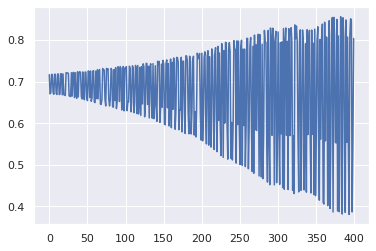

In [75]:
plt.plot(loss_meter.history)

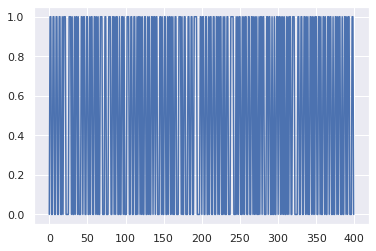

In [76]:
plt.plot(score_meter.history)

In [78]:
# score_meter.history